In [1]:
%cd drive

/content/drive


In [2]:
%cd MyDrive/AIND-VUI-Capstone/

/content/drive/MyDrive/AIND-VUI-Capstone


In [3]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import numpy as np
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
import soundfile
from numpy.lib.stride_tricks import as_strided
import sklearn
import json
import random
import _pickle as pickle
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, Lambda, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)

warnings.filterwarnings("ignore")

206168 22050


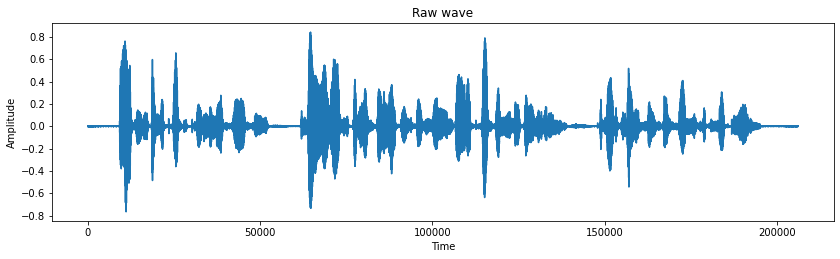

In [4]:
audio_path = 'LibriSpeech/Main Check.wav'
samples, sample_rate = librosa.load(audio_path)

print(len(samples), sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples), len(samples)), samples)
plt.show()

In [5]:
ipd.Audio(audio_path)

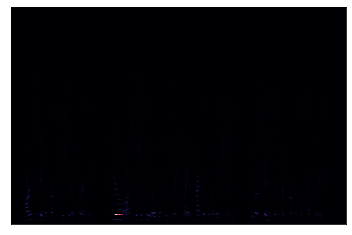

In [6]:
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)

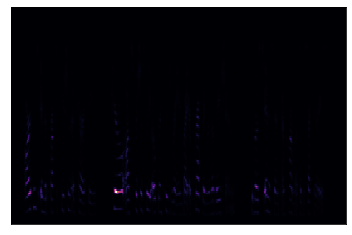

In [7]:
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram)

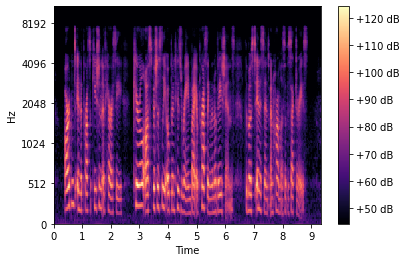

In [8]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [9]:
print(mel_sgram.shape)

(128, 403)


MFCC is of type <class 'numpy.ndarray'> with shape (20, 403)


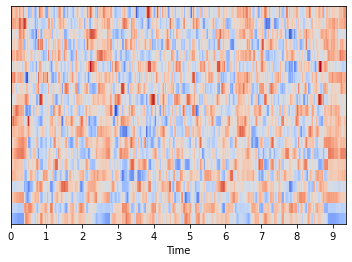

In [10]:
mfcc = librosa.feature.mfcc(samples, sr=sample_rate)

# Center MFCC coefficient dimensions to the mean and unit variance
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')

print (f'MFCC is of type {type(mfcc)} with shape {mfcc.shape}')
# MFCC is of type <class 'numpy.ndarray'> with shape (20, 134)

In [27]:
# Preprocessing Data Functions
"""
Defines two dictionaries for converting 
between text and integer sequences.
"""

char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""
# the "blank" character is mapped to 28

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride


def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        if c == 0:
          text.append("")
          continue
        ch = index_map[c]
        text.append(ch)
    return text

RNG_SEED = 123

class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        """
        Params:
            step (int): Step size in milliseconds between windows (for spectrogram ONLY)
            window (int): FFT window size in milliseconds (for spectrogram ONLY)
            max_freq (int): Only FFT bins corresponding to frequencies between
                [0, max_freq] are returned (for spectrogram ONLY)
            desc_file (str, optional): Path to a JSON-line file that contains
                labels and paths to the audio files. If this is None, then
                load metadata right away
        """

        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
        """ Obtain a batch of train, validation, or test data
        """
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # calculate necessary sizes
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # initialize the arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # calculate X_data & input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # calculate labels & label_length
            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)
 
        # return the arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_data_by_partition(self, partition):
        """ Shuffle the training or validation data
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def sort_data_by_duration(self, partition):
        """ Sort the training or validation sets by (increasing) duration
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def next_train(self):
        """ Obtain a batch of training data
        """
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_data_by_partition('train')
            yield ret    

    def next_valid(self):
        """ Obtain a batch of validation data
        """
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_data_by_partition('valid')
            yield ret

    def next_test(self):
        """ Obtain a batch of test data
        """
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret

    def load_train_data(self, desc_file='train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_data_by_duration('train')

    def load_validation_data(self, desc_file='valid_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_data_by_duration('valid')

    def load_test_data(self, desc_file='test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
        """ Read metadata from a JSON-line file
            (possibly takes long, depending on the filesize)
        Params:
            desc_file (str):  Path to a JSON-line file that contains labels and
                paths to the audio files
            partition (str): One of 'train', 'validation' or 'test'
        """
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    # Change to (KeyError, ValueError) or
                    # (KeyError,json.decoder.JSONDecodeError), depending on
                    # json module version
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
        """ Estimate the mean and std of the features from the training set
        Params:
            k_samples (int): Use this number of samples for estimation
        """
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + eps)

def shuffle_data(audio_paths, durations, texts):
    """ Shuffle the data (called after making a complete pass through 
        training or validation data during the training process)
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts


def sort_data(audio_paths, durations, texts):
    """ Sort the data by duration 
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

In [12]:
audio_gen = AudioGenerator(minibatch_size=20, spectrogram=True, mfcc_dim=13, max_duration=10.0, sort_by_duration=False)

In [13]:
spec_feature = audio_gen.normalize(audio_gen.featurize(audio_path))

In [14]:
spec_feature.shape

(934, 161)

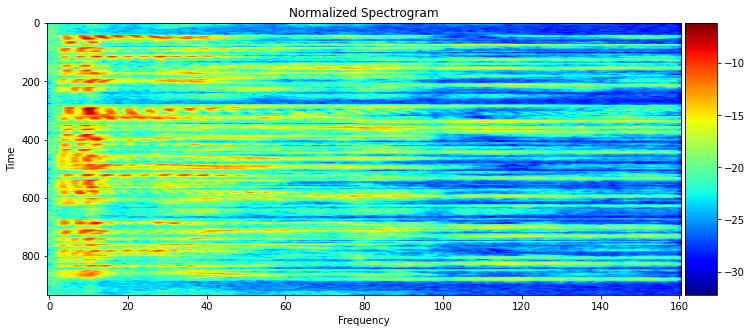

In [15]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
im = ax.imshow(spec_feature, cmap=plt.cm.jet, aspect='auto')
plt.title('Normalized Spectrogram')
plt.ylabel('Time')
plt.xlabel('Frequency')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [16]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model

def train_model(input_to_softmax, 
                pickle_path,
                save_model_path,
                train_json='train_corpus.json',
                valid_json='valid_corpus.json',
                minibatch_size=20,
                spectrogram=True,
                mfcc_dim=13,
                optimizer=SGD(learning_rate=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=3),
                epochs=20,
                verbose=1,
                sort_by_duration=False,
                max_duration=10.0):
    
    # create a class instance for obtaining batches of data
    # audio_gen = AudioGenerator(minibatch_size=minibatch_size, 
    #     spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
    #     sort_by_duration=sort_by_duration)
    # add the training data to the generator
    audio_gen.load_train_data(train_json)
    audio_gen.load_validation_data(valid_json)
    # calculate steps_per_epoch
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    # calculate validation_steps
    num_valid_samples = len(audio_gen.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size
    
    # add CTC loss to the NN specified in input_to_softmax
    model = add_ctc_loss(input_to_softmax)

    # CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

    # make results/ directory, if necessary
    if not os.path.exists('training_results'):
        os.makedirs('training_results')

    # add checkpointer
    checkpointer = ModelCheckpoint(filepath='training_results/'+save_model_path, verbose=0)

    # train the model
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, validation_data=audio_gen.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose)

    # save model loss
    with open('training_results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)

In [19]:
# Model - 1 : Basic RNN
input_data = Input(name='the_input', shape=(None, 161))
# Add recurrent layer
simp_rnn = GRU(200, activation='relu', return_sequences=True, implementation=2, name='rnn', reset_after=False)(input_data)
# TODO: Add batch normalization 
bn_rnn = BatchNormalization()(simp_rnn)
# TODO: Add a TimeDistributed(Dense(output_dim)) layer
time_dense = TimeDistributed(Dense(29))(bn_rnn)
# Add softmax activation layer
y_pred = Activation('softmax', name='softmax')(time_dense)
# Specify the model
model_1 = Model(inputs=input_data, outputs=y_pred)
model_1.output_length = lambda x: x
print(model_1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 161)]       0         
                                                                 
 rnn (GRU)                   (None, None, 200)         217200    
                                                                 
 batch_normalization (BatchN  (None, None, 200)        800       
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, None, 29)         5829      
 ibuted)                                                         
                                                                 
 softmax (Activation)        (None, None, 29)          0         
                                                                 
Total params: 223,829
Trainable params: 223,429
Non-trainable

In [ ]:
# train_model(input_to_softmax=model_1, 
#             pickle_path='model_1.pickle', 
#             save_model_path='model_1.h5',
#             spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 1145s 11s/step - loss: 288.9600 - val_loss: 240.2503
Epoch 2/20
101/101 [==============================] - 463s 5s/step - loss: 227.4303 - val_loss: 221.3290
Epoch 3/20
101/101 [==============================] - 467s 5s/step - loss: 195.6946 - val_loss: 208.8872
Epoch 4/20
101/101 [==============================] - 471s 5s/step - loss: 168.3933 - val_loss: 168.9565
Epoch 5/20
101/101 [==============================] - 470s 5s/step - loss: 155.7094 - val_loss: 153.1176
Epoch 6/20
101/101 [==============================] - 460s 5s/step - loss: 147.9031 - val_loss: 148.8346
Epoch 7/20
101/101 [==============================] - 461s 5s/step - loss: 142.2025 - val_loss: 147.8352
Epoch 8/20
101/101 [==============================] - 456s 5s/step - loss: 137.9036 - val_loss: 144.5175
Epoch 9/20
101/101 [==============================] - 457s 5s/step - loss: 134.0271 - val_loss: 140.9597
Epoch 10/20
101/101 [==============================] 

In [17]:
def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    print(prediction)
    print(prediction.shape)
    print(output_length)
    print(len(output_length))
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    print(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print(pred_ints)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

In [20]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=model_1, 
                model_path='training_results/model_1.h5')

[[[6.64993793e-09 9.81506858e-08 1.94168109e-07 ... 1.60207048e-08
   1.80751289e-08 9.99920607e-01]
  [1.74477373e-06 1.22481424e-07 1.79630716e-03 ... 8.40093999e-05
   8.67120150e-07 9.79498029e-01]
  [2.41817452e-06 1.87354701e-08 1.12152149e-04 ... 4.57701844e-06
   1.13781525e-07 9.99150991e-01]
  ...
  [8.94787391e-08 1.27634632e-06 7.73577142e-07 ... 3.81363094e-07
   5.51554358e-10 9.99720037e-01]
  [8.60251177e-08 1.47894809e-06 7.28346663e-07 ... 3.43444412e-07
   6.16381668e-10 9.99706805e-01]
  [1.29245606e-07 1.30904664e-06 8.70352324e-07 ... 5.11044107e-07
   9.17755705e-10 9.99603212e-01]]]
(1, 584, 29)
[584]
1
--------------------------------------------------------------------------------
LibriSpeech/dev-clean/1272/128104/1272-128104-0000.wav
True transcription:

mister quilter is the apostle of the middle classes and we are glad to welcome his gospel
[15, 7, 21, 2, 22, 17, 2, 5, 17, 22, 7, 20, 11, 21, 11, 18, 18, 18, 17, 21, 17, 2, 22, 10, 17, 2, 16, 3, 2, 5, 3, 21, 

In [24]:
input_data = Input(name='the_input', shape=(None, 161))
# TODO: Specify the layers in your network
# Add conv layer
conv_1d = Conv1D(200,
                  11,
                  strides=2,
                  padding='valid',
                  activation='relu',
                  name='conv1d')(input_data)
# Add BatchNormalization layer 1
bn_1 = BatchNormalization(name='bn_1')(conv_1d)
# Add rnn layer 1
rnn_1 = GRU(200,
            reset_after = False,
            activation='relu',
            return_sequences=True,
            implementation=2,
            dropout=0.2,
            recurrent_dropout=0.2,
            name='rnn_1')(bn_1)
# Add BatchNormalization layer 2
bn_2 = BatchNormalization(name='bn_2')(rnn_1)
# Add rnn layer 2
rnn_2 = GRU(100,
            reset_after = False,
            activation='relu',
            return_sequences=True,
            implementation=2,
            dropout=0.2,
            recurrent_dropout=0.2,
            name='rnn_2')(bn_2)
# Add time distributed dense layer
time_dense = TimeDistributed(Dense(29))(rnn_2)
# TODO: Add softmax activation layer
y_pred = Activation('softmax', name='softmax')(time_dense)
# Specify the model
model = Model(inputs=input_data, outputs=y_pred)
# TODO: Specify model.output_length
model.output_length = lambda x: cnn_output_length(x,
                                                  11,
                                                  'valid',
                                                  2)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 161)]       0         
                                                                 
 conv1d (Conv1D)             (None, None, 200)         354400    
                                                                 
 bn_1 (BatchNormalization)   (None, None, 200)         800       
                                                                 
 rnn_1 (GRU)                 (None, None, 200)         240600    
                                                                 
 bn_2 (BatchNormalization)   (None, None, 200)         800       
                                                                 
 rnn_2 (GRU)                 (None, None, 100)         90300     
                                                                 
 time_distributed_2 (TimeDis  (None, None, 29)         2929

In [28]:
# train_model(input_to_softmax=model, 
#             pickle_path='model_end.pickle', 
#             save_model_path='model_end.h5', 
#             spectrogram=True)

Epoch 1/20
101/101 [==============================] - 1110s 11s/step - loss: 226.9081 - val_loss: 195.8315
Epoch 2/20
101/101 [==============================] - 506s 5s/step - loss: 170.9169 - val_loss: 153.5265
Epoch 3/20
101/101 [==============================] - 503s 5s/step - loss: 150.0182 - val_loss: 143.1347
Epoch 4/20
101/101 [==============================] - 501s 5s/step - loss: 139.3926 - val_loss: 131.4539
Epoch 5/20
101/101 [==============================] - 506s 5s/step - loss: 131.6678 - val_loss: 129.4475
Epoch 6/20
101/101 [==============================] - 508s 5s/step - loss: 125.9289 - val_loss: 127.2953
Epoch 7/20
101/101 [==============================] - 509s 5s/step - loss: 121.1624 - val_loss: 123.0344
Epoch 8/20
101/101 [==============================] - 514s 5s/step - loss: 117.2337 - val_loss: 121.0534
Epoch 9/20
101/101 [==============================] - 513s 5s/step - loss: 113.6445 - val_loss: 120.2969
Epoch 10/20
101/101 [==============================] 

In [31]:
get_predictions(index=40, 
                partition='train',
                input_to_softmax=model, 
                model_path='training_results/model_end.h5')

[[[2.1616420e-06 1.9505886e-05 5.8765720e-05 ... 6.4281674e-05
   2.5470051e-08 9.9869722e-01]
  [1.8976814e-07 3.1132737e-07 1.2228720e-06 ... 7.6904644e-07
   1.8130568e-10 9.9996281e-01]
  [8.4319566e-08 2.7487621e-08 4.5899688e-07 ... 4.0036920e-08
   9.3153445e-12 9.9999487e-01]
  ...
  [1.8456272e-12 1.0506217e-13 2.1203085e-12 ... 7.4602047e-14
   1.4841827e-20 9.9999988e-01]
  [6.6412652e-12 3.9460156e-13 9.3947228e-12 ... 3.0317713e-13
   9.5150754e-20 9.9999988e-01]
  [1.0959079e-11 5.7415601e-13 1.2008150e-11 ... 4.1268941e-13
   2.1256295e-19 9.9999976e-01]]]
(1, 181, 29)
[181]
1
--------------------------------------------------------------------------------
LibriSpeech/dev-clean/1272/141231/1272-141231-0017.wav
True transcription:

he asked the handler who was kneading his aching muscles
[10, 7, 2, 10, 3, 21, 6, 2, 22, 10, 7, 2, 10, 3, 16, 6, 17, 2, 17, 20, 2, 10, 25, 3, 21, 2, 16, 2, 16, 7, 2, 6, 11, 16, 9, 2, 11, 21, 2, 11, 17, 16, 2, 16, 17, 21, 14, 7, 21, 0, 0, 0, 0, 